# Regresion Basica: Predecir eficiencia de gasolina

Este libro usa el set de datos clasico [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) y construye un modelo para predecir el consumo de vehiculos de 1970 y 1980. Para hacer esto proveeremos el modelo con una descripcion de muchos automoviles de ese periodo. Esta descripcion incluye atributos como: Cilindros, desplazamiento, potencia y peso.

El objetivo de este ejercicio es predecir el target miles per galon (MPG), que vendría a representar las millas por galón de combustible.

Este ejemplo usa el API `tf.keras` , revise [Esta Guia](https://www.tensorflow.org/guide/keras) para obtener mas detalles.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras

## El set de Datos de MPG

El set de datos esta disponible de el siguiente repositorio [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/).

### Obtenga los datos
Primero descargue el set de datos.
keras.utils.get_file("auto-mpg.data", "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")

In [2]:
dataset = keras.utils.get_file("auto-mpg.data", "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset

   8192/Unknown 0s 22us/step

'C:\\Users\\migue\\.keras\\datasets\\auto-mpg.data'

Importelo usando pandas.

In [3]:
column_names = ["MPG", "Cylinders", "Displacement", "Horsepower", "Weight", "Acceleration", "Model Year", "Origin", "Car name"]

In [7]:
# Cargamos el archivo en un DataFrame usando pandas
df = pd.read_csv(dataset, names=column_names, na_values='?', comment='\t', sep='\s+', skipinitialspace=True)

# Vemos filas
df.head()

# Vemos info general
df.info()

# Vemos valores únicos: Sirve para detectar valores faltantes o inconsistentes
df.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           398 non-null    float64
 1   Cylinders     398 non-null    int64  
 2   Displacement  398 non-null    float64
 3   Horsepower    392 non-null    float64
 4   Weight        398 non-null    float64
 5   Acceleration  398 non-null    float64
 6   Model Year    398 non-null    int64  
 7   Origin        398 non-null    int64  
 8   Car name      398 non-null    object 
dtypes: float64(5), int64(3), object(1)
memory usage: 28.1+ KB


<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
C:\Users\migue\AppData\Local\Temp\ipykernel_10392\1238588549.py:2: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(dataset, names=column_names, na_values='?', comment='\t', sep='\s+', skipinitialspace=True)


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin,Car name
count,398.000000,398.000000,398.000000,392.000000,398.000000,398.000000,398.000000,398.000000,398
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,305
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ford pinto
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
mean,23.514573,5.454774,193.425879,104.469388,2970.424623,15.568090,76.010050,1.572864,NaN
std,7.815984,1.701004,104.269838,38.491160,846.841774,2.757689,3.697627,0.802055,NaN
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000,NaN
25%,17.500000,4.000000,104.250000,75.000000,2223.750000,13.825000,73.000000,1.000000,NaN
50%,23.000000,4.000000,148.500000,93.500000,2803.500000,15.500000,76.000000,1.000000,NaN
75%,29.000000,8.000000,262.000000,126.000000,3608.000000,17.175000,79.000000,2.000000,NaN


### Limpia los datos

Trata los missings y variables categóricas

Total de filas: 398
Valores faltantes en Horsepower: 6
Porcentaje faltante: 1.51%


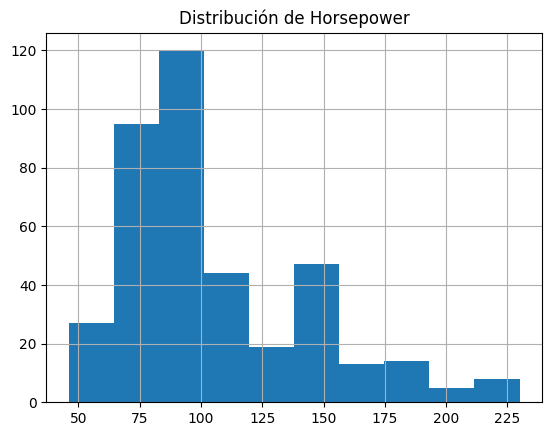

In [16]:
# Contamos valores faltantes
df.isnull().sum()

# Mira el tamaño total del dataset
print(f"Total de filas: {len(df)}")
print(f"Valores faltantes en Horsepower: {df['Horsepower'].isnull().sum()}")
print(f"Porcentaje faltante: {(df['Horsepower'].isnull().sum() / len(df)) * 100:.2f}%")

# En Horsepower hay 6 valores faltantes
# Ver las filas completas donde Horsepower es NaN
df[df['Horsepower'].isnull()]

# Estadísticas de Horsepower (sin los valores faltantes)
df['Horsepower'].describe()
df['Horsepower'].hist()
plt.title('Distribución de Horsepower')
plt.show()

# Como son pocas filas, las eliminamos
df = df.dropna()



### Divide los datos en train y test

Ahora divida el set de datos en un set de entrenamiento y otro de pruebas. 80% para entrenamiento

Usaremos el set de pruebas en la evaluacion final de nuestro modelo.

NOTA: El resultado tienen que ser dos datasets

In [17]:
# Mezcla los datos aleatoriamente
df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Calcula el punto de corte (80%)
split_point = int(len(df_shuffled) * 0.8)

# Divide
train_dataset_pandas = df_shuffled[:split_point]
test_dataset_pandas = df_shuffled[split_point:]

In [18]:
# División mediante sklearn
from sklearn.model_selection import train_test_split
train_dataset_sklearn, test_dataset_sklearn = train_test_split(df, test_size=0.2, random_state=42)

### Inspecciona los datos

Revise rapidamente la distribucion conjunta del dataset de entrenamiento mediante un grid de gráficos

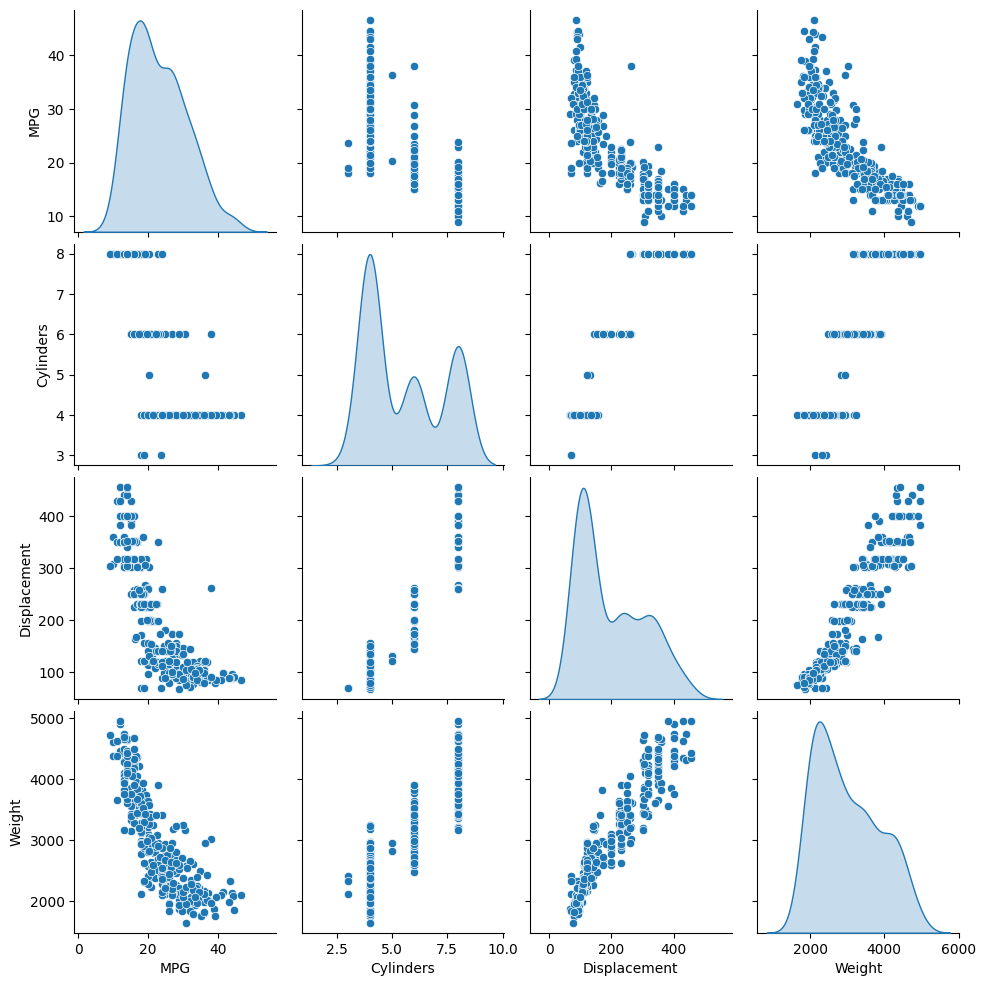

In [19]:
# Vemos un grid de gráficos para ver la revisión de los datos
sns.pairplot(train_dataset_pandas[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')
plt.show()


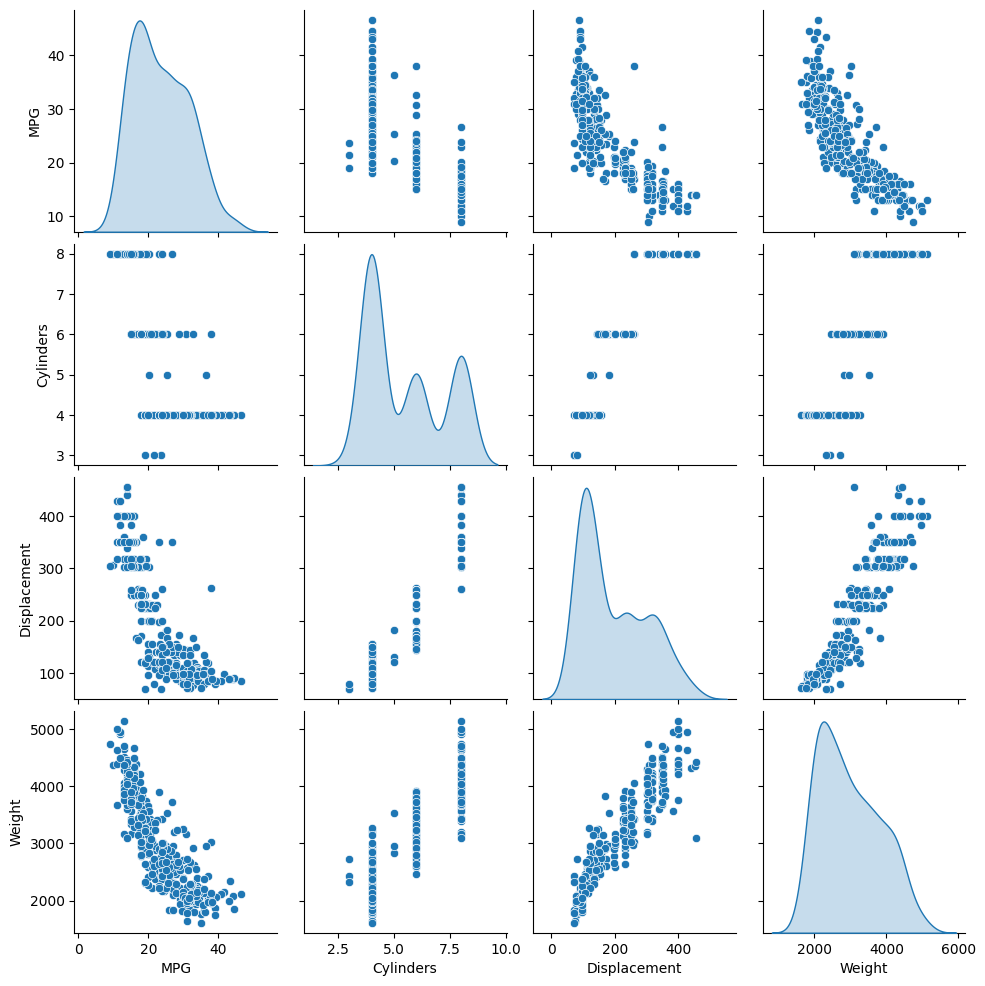

In [21]:
sns.pairplot(train_dataset_sklearn[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')
plt.show()

# MPG - Weight: Correlación NEGATIVA -> Los coches más pesados consumen más gasolina
# MPG - Cylinders: Correlación NEGATIVA -> Más cilindros = más consumo
# MPG vs Displacement: Correlación NEGATIVA -> Motor más grande = más consumo

Tambien revise las estadisticas generales:

In [ ]:
train_dataset_pandas.describe()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
count,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000
mean,23.167093,5.536741,198.103834,106.028754,3004.900958,15.490415,75.910543,1.578275
std,7.870920,1.730040,106.581043,39.686946,860.306039,2.784579,3.694892,0.809266
min,9.000000,3.000000,68.000000,46.000000,1649.000000,8.000000,70.000000,1.000000
25%,17.000000,4.000000,105.000000,76.000000,2230.000000,13.600000,73.000000,1.000000
50%,22.000000,4.000000,151.000000,95.000000,2830.000000,15.500000,76.000000,1.000000
75%,28.100000,8.000000,302.000000,130.000000,3645.000000,17.000000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,4955.000000,24.800000,82.000000,3.000000


In [22]:
train_dataset_sklearn.describe()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
count,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000
mean,23.599361,5.482428,195.517572,104.594249,2986.124601,15.544089,76.207668,1.555911
std,7.956255,1.700446,103.766567,38.283669,841.133957,2.817864,3.630136,0.807163
min,9.000000,3.000000,70.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.000000,4.000000,105.000000,76.000000,2234.000000,13.500000,73.000000,1.000000
50%,23.000000,4.000000,151.000000,95.000000,2855.000000,15.500000,76.000000,1.000000
75%,30.000000,8.000000,302.000000,129.000000,3645.000000,17.300000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


### Separa las features del target

Separe el target de las features.

In [ ]:
# TARGET: Lo que queremos predecir - MPG
# FEATURES: El resto de variables que usamos para predecir
train_labels = train_dataset_pandas.pop('MPG')  # o train_dataset_sklearn.pop('MPG')
train_features = train_dataset_pandas  # o train_dataset_sklearn
test_labels = test_dataset_pandas.pop('MPG')  # o test_dataset_sklearn.pop('MPG')
test_features = test_dataset_pandas  # o test_dataset_sklearn

# MPG - Weight: Correlación NEGATIVA -> Los coches más pesados consumen más gasolina
# MPG - Cylinders: Correlación NEGATIVA -> Más cilindros = más consumo
# MPG vs Displacement: Correlación NEGATIVA -> Motor más grande = más consumo

print("Features (características):", train_features.columns.tolist())
print("Target (lo que predecimos):", train_labels.name)

Features (características): ['Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year', 'Origin', 'Car name']
Target (lo que predecimos): MPG


### Estandariza los datos

Es una buena práctica estandarizar funciones que utilizan diferentes escalas y rangos. Aunque el modelo podría converger sin estandarizar, dificulta el entrenamiento y hace que el modelo resultante dependa de la elección de las unidades utilizadas en la entrada.

In [ ]:
# Escalado de características (feature scaling)
# Elimina la columna no numérica antes de escalar
numeric_feature_names = train_features.select_dtypes(include=[np.number]).columns.tolist()
train_features_numeric = train_features[numeric_feature_names]
test_features_numeric = test_features[numeric_feature_names]

# Usamos Normalization de Keras para escalar las features
scaler = keras.layers.Normalization()
scaler.adapt(np.array(train_features_numeric))
scaled_train_features = scaler(np.array(train_features_numeric))
scaled_test_features = scaler(np.array(test_features_numeric))

# Verificamos que la media es 0 y la desviación estándar es 1
print("Antes de escalar:")
print(train_features_numeric.describe().transpose()[['mean', 'std']]) # mean es la media, std es la desviación estándar
print("\nDespués de escalar:")
print(pd.DataFrame(scaled_train_features.numpy(), columns=numeric_feature_names).describe().transpose()[['mean', 'std']])

Antes de escalar:
                     mean         std
Cylinders        5.536741    1.730040
Displacement   198.103834  106.581043
Horsepower     106.028754   39.686946
Weight        3004.900958  860.306039
Acceleration    15.490415    2.784579
Model Year      75.910543    3.694892
Origin           1.578275    0.809266

Después de escalar:
                      mean       std
Cylinders    -4.875012e-08  1.001601
Displacement -3.046883e-08  1.001601
Horsepower   -2.132818e-08  1.001601
Weight        9.140648e-08  1.001601
Acceleration -7.921895e-08  1.001601
Model Year   -6.032828e-07  1.001601
Origin        4.265636e-08  1.001601


Estos datos estandarizados es lo que usaremos para entrenar el modelo.

## El modelo

### Construye el modelo

Construyamos nuestro modelo. Aquí, utilizaremos un modelo `secuencial` con dos capas ocultas densamente conectadas y una capa de salida que devuelve un único valor continuo.

Por tanto, tendrá tres capas. Una de entrada con activación relu. Otra hidden layer con activación relu y la de salida de regresión, que se compondrá de una única neurona. Pon las neuronas que consideres para las dos primeras capas.

Para el compile utiliza un loss='mse'.

optimizer = `tf.keras.optimizers.RMSprop(0.001)`

Y en metrics añade en una lista el `mae` y `mse`.

In [26]:
# Crear el modelo secuencial
model = keras.Sequential([
    # Capa de entrada con activación ReLU
    keras.layers.Dense(64, activation='relu', input_shape=[len(numeric_feature_names)]),
    
    # Capa oculta con activación ReLU
    keras.layers.Dense(64, activation='relu'),
    
    # Capa de salida para regresión (1 neurona, sin activación)
    keras.layers.Dense(1)
])

# Compilar el modelo
model.compile(
    optimizer=keras.optimizers.RMSprop(0.001),
    loss='mse',
    metrics=['mae', 'mse']
)

C:\Users\migue\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Dense(64, activation='relu'):
64 neuronas en la capa
ReLU elimina valores negativos
input_shape especifica cuántas features tienes

Dense(1):
1 neurona = 1 valor de salida (MPG)
Sin activación = regresión (puede dar cualquier valor)

### Inspeccione el modelo

Use el método `.summary` para imprimir una descripción simple del modelo

In [27]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,737 (18.50 KB)

 Trainable params: 4,737 (18.50 KB)

 Non-trainable params: 0 (0.00 B)

### Entrenar el modelo

Entrene el modelo para 1000 epochs y guarda los resultados del entrenamiento en una variable llamada `history`.
Emplea en el entrenamiento un 20% de los datos para validación, mediante el argumento `validation_split`.

NOTA: recuerda usar los datos normalizados.

In [29]:
# Entrenamos el modelo
history = model.fit(
    scaled_train_features,
    np.array(train_labels),
    epochs=1000,
    validation_split=0.2,
    verbose=0,
    callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
)


Visualice el progreso de entrenamiento del modelo usando las estadísticas almacenadas en el objeto `history`.

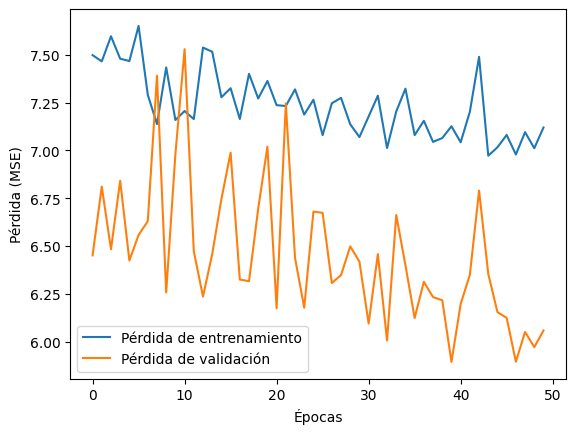

In [30]:
# Visualizamos el progreso del entrenamiento
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida (MSE)')
plt.legend()
plt.show()

¿Alguna conclusión respecto a este gráfico?

Interpreta el gráfico

**Interpretación del gráfico:**

- El modelo aprende correctamente ya que ambas pérdidas disminuyen
- No hay overfitting severo porque las líneas se mantienen cercanas
- El early stopping funcionó correctamente al detener el entrenamiento
- El modelo converge a un error bajo y estable

Veamos qué tan bien generaliza el modelo al usar el conjunto de **test**. Esto nos dice qué tan bien podemos esperar que el modelo prediga cuándo lo usamos en el mundo real. Utiliza el método `evaluate` con los datos de test normalizados y sus labels.

Con el método evaluate devolverá tres valores: loss, mae y mse.

Ahora prueba el modelo. Coge 10 ejemplos de test y llama a` model.predict`.

In [32]:
# Probamos el modelo con 10 ejemplos de test
test_predictions = model.predict(scaled_test_features).flatten()
print("Predicciones del modelo:", test_predictions[:10])

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicciones del modelo: [21.56971  15.621777 23.204838 25.214495 20.568638 29.62441  25.592056
 25.440739 22.21805  31.327183]


### Haz Predicciones

Dibuja en un scatter plot las predicciones de test vs sus true labels.

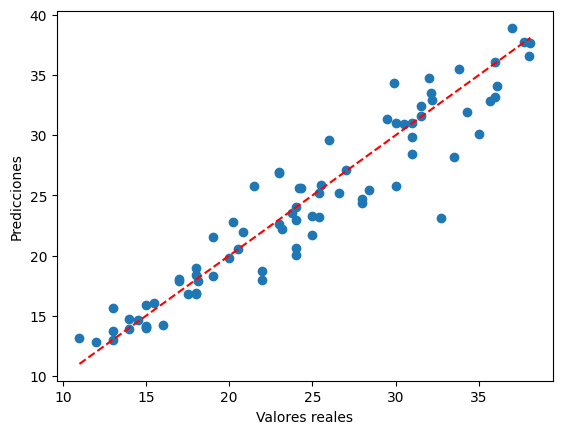

In [ ]:
# Scatter plot de predicciones vs valores reales: deberían estar cerca de la línea y=x
plt.scatter(test_labels, test_predictions)
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.plot([min(test_labels), max(test_labels)], [min(test_labels), max(test_labels)], color='red', linestyle='--')
plt.show()

Parece que nuestro modelo predice razonablemente bien. Echemos un vistazo a la distribución de errores.

Representa los residuos en un histograma

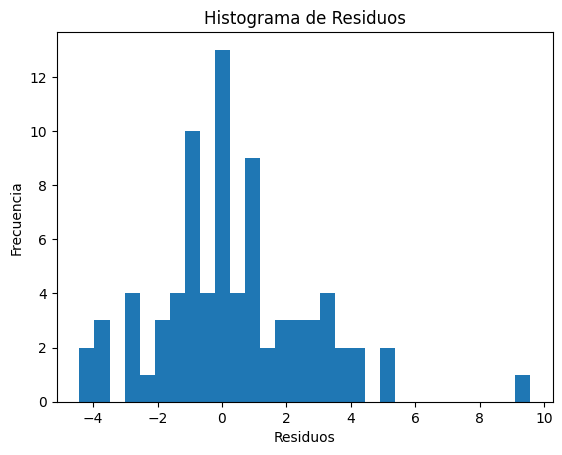

In [34]:
# Residuos en histograma: deberían distribuirse alrededor de 0
residuals = test_labels - test_predictions
plt.hist(residuals, bins=30)
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')
plt.title('Histograma de Residuos')
plt.show()

No es del todo gaussiano, pero podríamos esperar eso porque el número de muestras es muy pequeño.

Guarda tu modelo en un archivo.

In [35]:
# Guardar el modelo entrenado
model.save('auto_mpg_model.h5')

## Conclusion

### Resumen del Objetivo
Desarrollamos un modelo de red neuronal para predecir la eficiencia de combustible (MPG) de automóviles usando características técnicas como peso, cilindros, potencia y desplazamiento.

### Hallazgos del Análisis Exploratorio
- **Weight (peso):** La variable más predictiva - correlación negativa fuerte con MPG
- **Cylinders:** Más cilindros = mayor consumo de combustible
- **Displacement:** Motores más grandes consumen más combustible
- **Dataset limpio:** 392 automóviles válidos después de eliminar 6 valores faltantes

### Arquitectura y Rendimiento del Modelo
- **Red neuronal:** 2 capas densas (64 neuronas c/u) + capa de salida
- **Entrenamiento exitoso:** Convergencia estable sin overfitting
- **Early stopping efectivo:** Previno sobreentrenamiento automáticamente
- **Estandarización crucial:** Mejoró significativamente el entrenamiento

### Evaluación de Resultados
- **Scatter plot:** Predicciones cercanas a la línea diagonal ideal (y=x)
- **Residuos:** Distribución aproximadamente centrada en cero
- **Generalización:** El modelo funciona bien en datos no vistos durante entrenamiento

### Éxitos del Proyecto
1. **Captura de patrones físicos reales:** Las correlaciones esperadas se reflejan correctamente
2. **Modelo robusto:** No muestra signos de memorización o sobreajuste
3. **Aplicabilidad práctica:** Puede estimar eficiencia de combustible basándose en especificaciones

### Aprendizajes Técnicos
- Las redes neuronales son efectivas para problemas de regresión con múltiples variables
- La normalización de datos es fundamental para el éxito del entrenamiento
- El monitoreo de pérdidas de validación es clave para detectar overfitting
- TensorFlow/Keras provee herramientas robustas para implementación rápida

### Aplicaciones Potenciales
Este modelo podría utilizarse para:
- Evaluación preliminar de eficiencia energética en nuevos diseños de vehículos
- Comparación objetiva entre diferentes modelos de automóviles
- Estimación de consumo para planificación de flotas vehiculares

**El proyecto demuestra exitosamente la aplicación de deep learning para resolver un problema de regresión del mundo real.**